In [ ]:
import torch
import random
from torch import nn, save, load
from torchvision import datasets
import math
import matplotlib.pyplot as plt

In [ ]:
# Load the model.pt file
PATH = "model.pt"
model_params_dict = torch.load(PATH,map_location=torch.device('cpu'))
model_params = model_params_dict["model_state_dict"]

<ipython-input-2-1bcc3ea7d45b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params_dict = torch.load(PATH,map_location=torch.device('cpu'))


In [ ]:
model_params.keys()

odict_keys(['model.0.weight', 'model.0.bias', 'model.4.weight', 'model.4.bias'])

In [ ]:
model_params['model.0.weight'].shape

torch.Size([8, 1, 5, 5])

In [ ]:
arch_name = "bare"

weight_file = open("c_weights.cpp", 'w')
weight_file.write("#include \"{}_param_def.h\"".format(arch_name))
weight_file.write("typedef float DTYPE; \n\n")

param_file = open("{}_param_def.h".format(arch_name))
param_file.write("#ifndef PARAM_DEF\n")
param_file.write("#define PARAM_DEF\n\n")

# Package the different layers into one c_weights.h by iterating through idc
for i,(name, param) in enumerate(model_params.items()):
    idx = int(math.floor(i/2 + 1))

    if (len(param.shape)==4): # conv params

        conv_N, conv_C, conv_H, conv_W = param.shape
        param_tensor = param.data

        param_file.write("\t #define CONV_{}_WEIGHTS_N {} \n".format(idx, conv_N))
        param_file.write("\t #define CONV_{}_WEIGHTS_C {} \n".format(idx, conv_C))
        param_file.write("\t #define CONV_{}_WEIGHTS_H {} \n".format(idx, conv_H))
        param_file.write("\t #define CONV_{}_WEIGHTS_W {} \n".format(idx, conv_W))

        weight_file.write("\n DTYPE CONV_{}_WEIGHTS[CONV_{}_WEIGHTS_N * CONV_{}_WEIGHTS_C * CONV_{}_WEIGHTS_H * CONV_{}_WEIGHTS_W] = \n".format(idx,idx,idx,idx,idx))

        weight_file.write("\n { \n") # layer opening brac

        for fil_num in range(conv_N):
            weight_file.write("\t \n") # filter open brac

            for kernel_num in range(conv_C):
                weight_file.write("\t\t \n")  #kernel opening brac

                for kernel_row in range(conv_H):
                    for kernel_col in range(conv_W):
                        weight_file.write("\t {}, ".format(param[fil_num][kernel_num][kernel_row][kernel_col]))

            weight_file.write("\t \n") # filter closing brac


        weight_file.write("\n }; \n") # layer closing brac
        prev_flag = "CONV"

    if (len(param.shape)==2):   # dense param

        dense_H, dense_W = param.shape
        param_tensor = param.data

        weight_file.write("\n #define DENSE_{}_WEIGHTS_H {} \n".format(idx, dense_H))
        weight_file.write("\n #define DENSE_{}_WEIGHTS_W {} \n".format(idx, dense_W))

        weight_file.write("\n DTYPE DENSE_{}_WEIGHTS[DENSE_{}_WEIGHTS_H * DENSE_{}_WEIGHTS_W] = \n".format(idx,idx,idx))

        weight_file.write("\n { \n") # dense opening brac

        for dense_row in range(dense_H):
            weight_file.write("\n")
            for dense_col in range(dense_W):
                weight_file.write("\t {},".format(param_tensor[dense_row][dense_col]))

        weight_file.write("\n }; \n") # dense closing brac
        prev_flag = "DENSE"

    if (len(param.shape)==1):   # bias param

        bias_L = param.shape[0]
        param_tensor = param.data

        weight_file.write("\n #define {}_{}_BIAS_N {} \n".format(prev_flag, idx, bias_L))
        weight_file.write("\n DTYPE {}_{}_BIAS[{}_{}_BIAS_N] = \n".format(prev_flag, idx, prev_flag, idx))
        weight_file.write("\n { \n") # opening brac

        for i in range(bias_L):
            weight_file.write("\t {},".format(param_tensor[i]))


        weight_file.write("\n }; \n") # closing brac

weight_file.close()



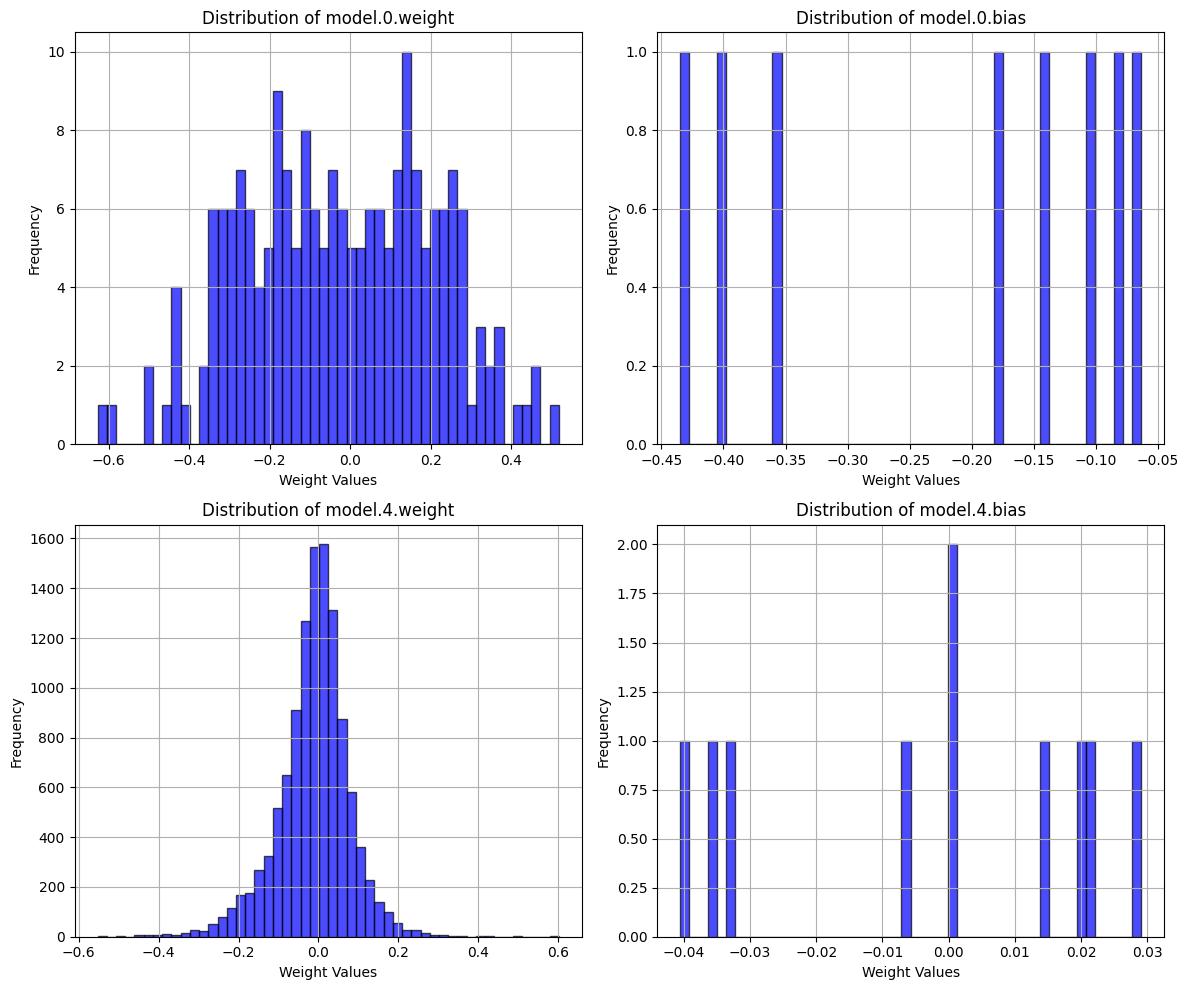

In [ ]:
# Checking weight, images, labels distribution to adjust fixed point bit widths
def weight_plot(model_params):
    fig, axes = plt.subplots(int(len(model_params.keys())/2), 2, figsize=(12, 10))
    axes = axes.flatten()

    for i,(name, param) in enumerate(model_params.items()):
        axes[i].hist(param.numpy().flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of ' + str(name))
        axes[i].set_xlabel('Weight Values')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

weight_plot(model_params)